## Train a Detector on A Customized Dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection:
  1. Reorganize the dataset into a COCO format
  2. Reorganize the dataset into a middle format
  3. Implement a new dataset

We recommend the first two methods, as they are usually easier than the third.

In this tutorial, we give an example that converts the data into COCO format because MMDetection **only support evaluating mask AP of dataset in COCO format for now**. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/advanced_guides/customize_dataset.html).

First, let's download the [the balloon dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon).

# Check the directory structure of the tiny data

# Install tree first in your terminal(linux)
sudo apt-get -q install tree


In [20]:
!find /mmdetection/grape/data/fastgrape/grape/fuji/train/ -type f -name "*label.png" -exec bash -c 'mv "$1" "${1/_label.png/.png}"' _ {} \;

1448.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [1]:
!find /mmdetection/grape/data/fastgrape/grape/fuji/ -type f -name "*label.png" -exec mv {} /mmdetection/grape/data/fastgrape/grape/fuji/train/label/ \;
!find /mmdetection/grape/data/fastgrape/grape/fuji/train/label/ -type f -name "*label.png" -exec bash -c 'mv "$1" "${1/_label.png/.png}"' _ {} \;

mv: '/mmdetection/grape/data/fastgrape/grape/fuji/train/label/middle_fuji222_05_label.png' and '/mmdetection/grape/data/fastgrape/grape/fuji/train/label/middle_fuji222_05_label.png' are the same file
mv: '/mmdetection/grape/data/fastgrape/grape/fuji/train/label/middle_fuji227_04_label.png' and '/mmdetection/grape/data/fastgrape/grape/fuji/train/label/middle_fuji227_04_label.png' are the same file
mv: '/mmdetection/grape/data/fastgrape/grape/fuji/train/label/middle_fuji224_04_label.png' and '/mmdetection/grape/data/fastgrape/grape/fuji/train/label/middle_fuji224_04_label.png' are the same file
mv: '/mmdetection/grape/data/fastgrape/grape/fuji/train/label/before_fuji246_06_label.png' and '/mmdetection/grape/data/fastgrape/grape/fuji/train/label/before_fuji246_06_label.png' are the same file
mv: '/mmdetection/grape/data/fastgrape/grape/fuji/train/label/middle_fuji264_03_label.png' and '/mmdetection/grape/data/fastgrape/grape/fuji/train/label/middle_fuji264_03_label.png' are the same file


In [2]:
!find /mmdetection/grape/data/fastgrape/grape/fuji/ -type f -name "*rgb.JPG" -exec mv {} /mmdetection/grape/data/fastgrape/grape/fuji/train/color/ \;
!find /mmdetection/grape/data/fastgrape/grape/fuji/train/color/ -type f -name "*rgb.JPG" -exec bash -c 'mv "$1" "${1/_rgb.JPG/.JPG}"' _ {} \;

mv: '/mmdetection/grape/data/fastgrape/grape/fuji/train/color/before_fuji260_06_rgb.JPG' and '/mmdetection/grape/data/fastgrape/grape/fuji/train/color/before_fuji260_06_rgb.JPG' are the same file
mv: '/mmdetection/grape/data/fastgrape/grape/fuji/train/color/before_fuji246_07_rgb.JPG' and '/mmdetection/grape/data/fastgrape/grape/fuji/train/color/before_fuji246_07_rgb.JPG' are the same file
mv: '/mmdetection/grape/data/fastgrape/grape/fuji/train/color/middle_fuji240_05_rgb.JPG' and '/mmdetection/grape/data/fastgrape/grape/fuji/train/color/middle_fuji240_05_rgb.JPG' are the same file
mv: '/mmdetection/grape/data/fastgrape/grape/fuji/train/color/before_fuji258_03_rgb.JPG' and '/mmdetection/grape/data/fastgrape/grape/fuji/train/color/before_fuji258_03_rgb.JPG' are the same file
mv: '/mmdetection/grape/data/fastgrape/grape/fuji/train/color/middle_fuji225_04_rgb.JPG' and '/mmdetection/grape/data/fastgrape/grape/fuji/train/color/middle_fuji225_04_rgb.JPG' are the same file
mv: '/mmdetection/gr

In [18]:
!find /mmdetection/grape/data/fastgrape/grape/fuji/val -type f -name "*label.png" -exec mv {} /mmdetection/grape/data/fastgrape/grape/fuji/val/label/ \;
!find /mmdetection/grape/data/fastgrape/grape/fuji/val/label/ -type f -name "*label.png" -exec bash -c 'mv "$1" "${1/_label.png/.png}"' _ {} \;

In [16]:
!find /mmdetection/grape/data/fastgrape/grape/fuji/val -type f -name "*rgb.JPG" -exec mv {} /mmdetection/grape/data/fastgrape/grape/fuji/val/color/ \;
!find /mmdetection/grape/data/fastgrape/grape/fuji/val/color/ -type f -name "*rgb.JPG" -exec bash -c 'mv "$1" "${1/_rgb.JPG/.JPG}"' _ {} \;


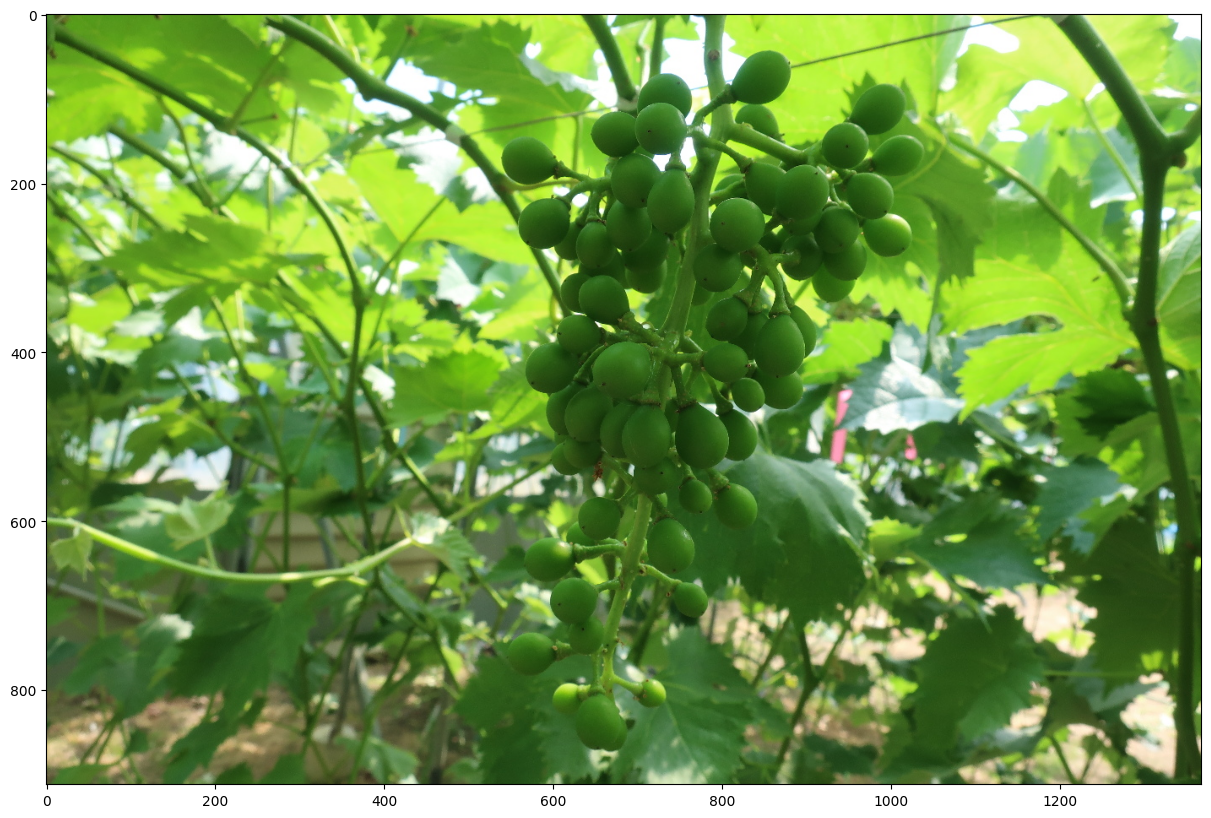

In [1]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/mmdetection/grape/data/fastgrape/grape/fuji/train/color/before_fuji241_03.JPG')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Checking the label corresponding to the instance split ID after the data format conversion is complete

In [1]:
!python preprocessing/Mask2polygon.py /mmdetection/grape/data/resize/train/label

preprocessing start with /mmdetection/grape/data/resize/train/label/
0
before_fuji241_03.png
1
before_fuji243_05.png
2
before_fuji246_05.png
3
before_fuji246_06.png
4
before_fuji246_07.png
5
before_fuji248_02.png
6
before_fuji250_03.png
7
before_fuji258_02.png
8
before_fuji258_03.png
9
before_fuji258_07.png
10
before_fuji258_09.png
11
before_fuji259_06.png
12
before_fuji260_03.png
13
before_fuji260_06.png
14
before_fuji260_07.png
15
before_fuji262_04.png
16
before_fuji262_08.png
17
middle_fuji222_05.png
18
middle_fuji222_08.png
19
middle_fuji224_04.png
20
middle_fuji224_09.png
21
middle_fuji225_04.png
22
middle_fuji225_05.png
23
middle_fuji226_04.png
24
middle_fuji227_02.png
25
middle_fuji227_04.png
26
middle_fuji227_08.png
27
middle_fuji228_03.png
28
middle_fuji228_06.png
29
middle_fuji229_02.png
30
middle_fuji232_07.png
31
middle_fuji234_04.png
32
middle_fuji234_05.png
33
middle_fuji234_09.png
34
middle_fuji235_04.png
35
middle_fuji235_06.png
36
middle_fuji238_02.png
37
middle_fuji23

In [2]:
!python preprocessing/Mask2polygon.py /mmdetection/grape/data/resize/val/label/

preprocessing start with /mmdetection/grape/data/resize/val/label/
0
after_fuji225_04.png
1
before_fuji222_02.png
2
before_fuji222_04.png
3
before_fuji222_05.png
4
before_fuji223_02.png
5
before_fuji223_03.png
6
before_fuji223_04.png
7
before_fuji223_05.png
8
before_fuji224_02.png
9
before_fuji224_05.png
10
before_fuji224_06.png
11
before_fuji225_02.png
12
before_fuji225_04.png
13
before_fuji226_02.png
14
before_fuji226_03.png
15
before_fuji227_02.png
16
before_fuji227_03.png
17
before_fuji227_04.png
18
before_fuji227_05.png
19
before_fuji227_06.png
20
before_fuji227_07.png
21
before_fuji228_04.png
22
before_fuji229_02.png
23
before_fuji234_02.png
24
before_fuji234_03.png
25
before_fuji234_05.png
26
before_fuji234_06.png


In [1]:
from pycocotools.coco import COCO

# Path to load the COCO annotation file
annotation_file = '/mmdetection/grape/data/resize_blur10/train/annotation_coco.json'

# Initialise the COCO object
coco = COCO(annotation_file)

# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Category ID: 1, Category Name: grape_berry


### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [2]:
from mmengine import Config
cfg = Config.fromfile('../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-1x_coco.py')

Given a config that trains a Mask R-CNN on COCO dataset, we need to modify some values to use it for training on the balloon dataset.

In [3]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('grape_berry', ),
    'palette': [
        (220, 20, 60),
    ]
}

# Modify dataset type and path
cfg.data_root = './data/resize_blur10'

cfg.train_dataloader.dataset.ann_file = 'train/annotation_coco.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/color'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'val/annotation_coco.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'val/color/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'val/annotation_coco.json'
cfg.test_evaluator = cfg.val_evaluator

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = '../checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'


# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [4]:
!python ../tools/train.py {config}

05/15 04:18:39 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.8 (main, Nov  4 2022, 13:48:29) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1817293139
    GPU 0,1,2,3,4,5,6,7: NVIDIA GeForce RTX 3090
    CUDA_HOME: /opt/conda
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.13.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_

### Understand the log
From the log, we can have a basic understanding on the training process and know how well the detector is trained.

First, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the original Mask R-CNN is trained on COCO dataset that contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layers of the pre-trained Mask R-CNN for classification and regression have different weight shape and are not used. The pre-trained weights of mask prediction layer `mask_head.conv_logits` also does not matches the current model and is not used due to similar reason.

Third, after training, the detector is evaluated by the default COCO-style evaluation. The results show that the detector achieves 79.6 bbox AP and 81.5 mask AP on the val dataset, not bad!

 We can also check the tensorboard to see the curves.

In [5]:
%pip install tensorboard  -i https://mirrors.ustc.edu.cn/pypi/web/simple

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple
Note: you may need to restart the kernel to use updated packages.


In [6]:
# load tensorboard in jupyter notebook
%load_ext tensorboard

In [7]:
# see curves in tensorboard
# if you see <IPython.core.display.HTML object> please run it again
%tensorboard --logdir tutorial_exps/

Reusing TensorBoard on port 6006 (pid 73392), started 13 days, 1:31:43 ago. (Use '!kill 73392' to kill it.)

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

In [12]:
import mmcv
from mmdet.apis import init_detector, inference_detector
img = mmcv.imread('/mmdetection/grape/data/defisheye/frame0.jpg',channel_order='rgb')
checkpoint_file = 'tutorial_exps/epoch_12.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)
print(new_result)

Loads checkpoint by local backend from path: tutorial_exps/epoch_12.pth
<DetDataSample(

    META INFORMATION
    img_path: None
    pad_shape: (800, 800)
    scale_factor: (1.6666666666666667, 1.6666666666666667)
    batch_input_shape: (800, 800)
    img_shape: (800, 800)
    ori_shape: (480, 480)
    img_id: 0

    DATA FIELDS
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            scores: tensor([0.9290, 0.9186, 0.7397, 0.6362, 0.6198, 0.5769, 0.5689, 0.5118, 0.4123,
                        0.1903, 0.1708, 0.1609, 0.1485, 0.1140, 0.0922, 0.0910, 0.0886, 0.0818,
                        0.0790, 0.0695, 0.0684, 0.0673, 0.0630, 0.0628, 0.0624, 0.0623, 0.0602,
                        0.0599, 0.0588, 0.0567, 0.0565, 0.0533, 0.0525, 0.0521, 0.0508])
            bboxes: tensor([[210.2939, 267.8679, 234.7567, 290.8976],
                        [249.0886, 323.2330, 269.6214, 348.3803],
                        [183.0977, 408.9762, 3

In [13]:
from mmengine.visualization import Visualizer
# get built visualizer
visualizer_now = Visualizer.get_current_instance()
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer_now.dataset_meta = model.dataset_meta
# show the results
visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    out_file=None,
    pred_score_thr=0.5
)
visualizer_now.show()

RuntimeError: Before calling Visualizer.get_current_instance(), you should call get_instance(name=xxx) at least once.

In [8]:
import mmcv
from mmengine.visualization import Visualizer
from mmdet.registry import VISUALIZERS
from mmdet.apis import init_detector, inference_detector
import os

def show_result_pyplot(img_folder_path):
    checkpoint_file = 'tutorial_exps/epoch_12.pth'
    model = init_detector(cfg, checkpoint_file, device='cpu')
    visualizer = VISUALIZERS.build(model.cfg.visualizer)
    visualizer.dataset_meta = model.dataset_meta
    for img_path in os.listdir(img_folder_path):
        img = mmcv.imread(img_folder_path + img_path, channel_order='rgb')
        new_result = inference_detector(model, img)
        visualizer.add_datasample(
            'new_result',
            img,
            data_sample=new_result,
            draw_gt=False,
            wait_time=0,
            out_file=f'./output/resize_blur10/{img_path}',
            pred_score_thr=0.5
        )

In [9]:
image_folder = '/mmdetection/grape/data/fisheye/'
show_result_pyplot(image_folder)

Loads checkpoint by local backend from path: tutorial_exps/epoch_12.pth


/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.TensorboardVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


## What to Do Next?

So far, we have learnt how to test and train Mask R-CNN. To further explore the segmentation task, you could do several other things as shown below:

- Try cascade methods, e.g., [Cascade Mask R-CNN](https://github.com/open-mmlab/mmdetection/tree/master/configs/cascade_rcnn) and [HTC](https://github.com/open-mmlab/mmdetection/tree/master/configs/htc) in [MMDetection model zoo](https://github.com/open-mmlab/mmdetection/blob/master/docs/en/model_zoo.md). They are powerful detectors that are ranked high in many benchmarks, e.g., COCO dataset.
- Try single-stage methods, e.g., [K-Net](https://github.com/ZwwWayne/K-Net) and [Dense-RepPoints](https://github.com/justimyhxu/Dense-RepPoints). These two algorithms are based on MMDetection. Box-free instance segmentation is a new trend in the instance segmentation community.
- Try semantic segmentation. Semantic segmentation is also a popular task with wide applications. You can explore [MMSegmentation](https://github.com/open-mmlab/mmsegmentation/); we also provide a [colab tutorial](https://github.com/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb) for semantic segmentation using MMSegmentation.
